In [3]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from ridge import Ridge_
from sklearn.metrics import mean_absolute_error
from math import inf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_csv('olympics_100m.csv', sep=',')
train, test = train_test_split(df, test_size=0.2, random_state=1)

In [5]:
predictor = 'Year'
target = 'Time'

In [6]:
X = train[predictor].values
y = train[target].values

In [7]:
X_test = test[predictor].values
y_test = test[target].values

In [8]:
# don't know if required ??
# Centering and normalizing the data so that the effect of the intercept
# (bias) is not so relevant
x_mean = X.mean()
x_std = X.std()

# scale the data
X = (X - x_mean) / x_std
X = X.reshape(len(train), 1)

In [9]:
X_test = (X_test - x_mean) / x_std
X_test = X_test.reshape(len(test), 1)

In [10]:
poly = PolynomialFeatures(1)
X = poly.fit_transform(X)
X_test = poly.fit_transform(X_test)

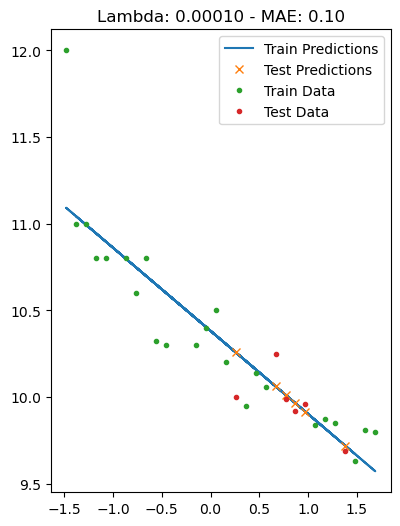

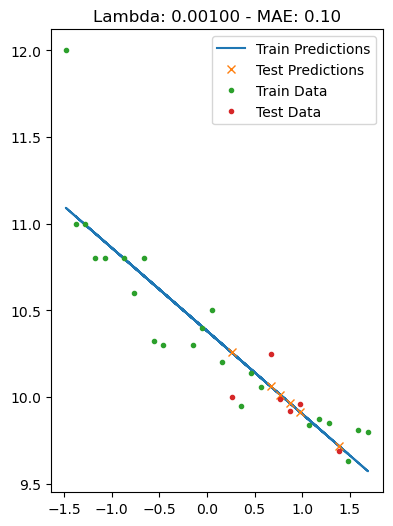

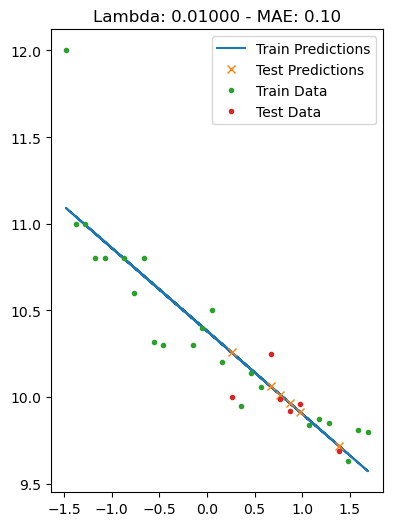

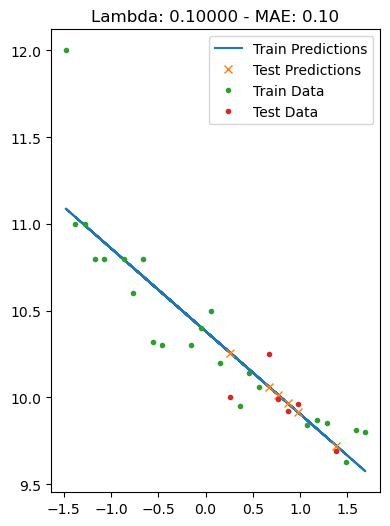

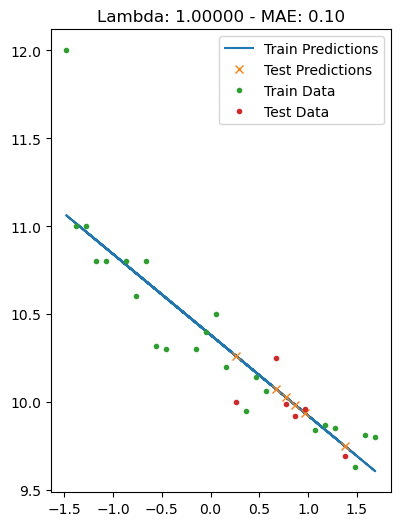

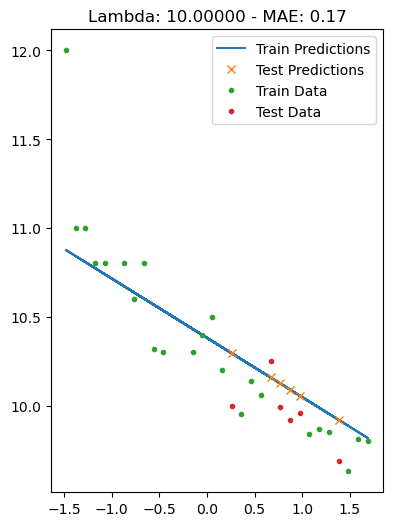

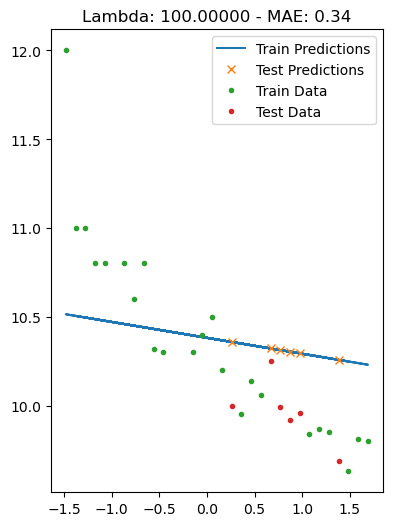

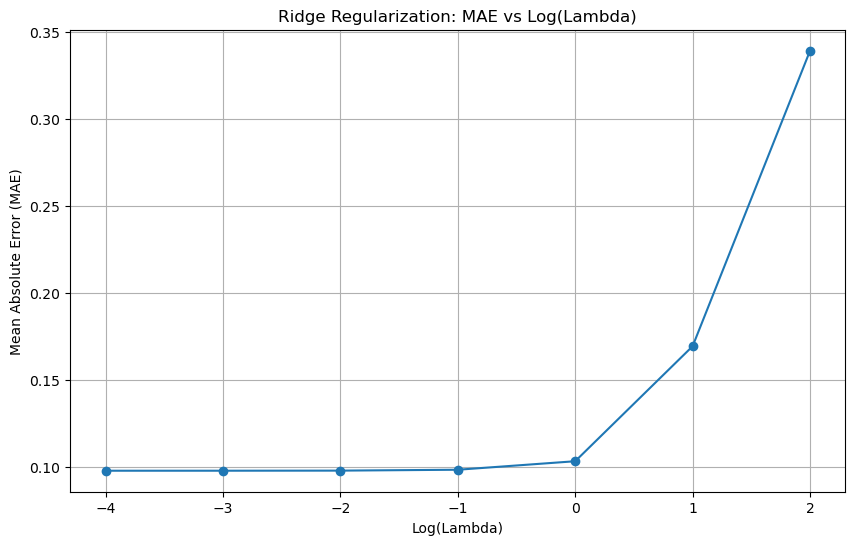

In [11]:
lambda_values = [10**i for i in range(-4, 3)]
errors = []
min_error = inf
best_l = 0
for l in lambda_values:
    ridge_model = Ridge_(l)
    w = ridge_model.ridge_fit(X, y)
    y_hat = ridge_model.ridge_predict(X)
    y_hat_test = ridge_model.ridge_predict(X_test)
    # Convert lambda to an integer for subplot index
    l_index = lambda_values.index(l) + 1
    e = mean_absolute_error(y_test, y_hat_test)
    errors.append(e)
    if e < min_error:
        min_error = e
        best_l = l
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 4, l_index)
    plt.tight_layout()
    plt.plot(X[:, 1], y_hat, label='Train Predictions')
    plt.plot(X_test[:, 1], y_hat_test, 'x', label='Test Predictions')
    plt.plot(X[:, 1], y, '.', label='Train Data')
    plt.plot(X_test[:, 1], y_test, '.', label='Test Data')
    plt.title('Lambda: {:.5f} - MAE: {:.2f}'.format(l, mean_absolute_error(y_test, y_hat_test)))
    plt.legend()

# Plotting MAE vs Log(Lambda)
plt.figure(figsize=(10, 6))
plt.plot(np.log10(lambda_values), errors, marker='o')
plt.title('Ridge Regularization: MAE vs Log(Lambda)')
plt.xlabel('Log(Lambda)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.show()

In [12]:
ridge_model = Ridge_(best_l)
w = ridge_model.ridge_fit(X, y)
predictions = ridge_model.ridge_predict(X_test)

array([10.38130435, -0.4799017 ])

In [13]:
# test with sklearn
ridge_model2 = Ridge(alpha=best_l)
ridge_model2.fit(X[:, 1].reshape(-1, 1), y)
ridge_model2.intercept_, ridge_model2.coef_

(10.38130434782609, array([-0.4799017]))

In [18]:
sklearn_predictions = ridge_model2.predict(X_test[:, 1].reshape(-1, 1))
# difference between our model predicions and sklearn ones
diff = predictions - sklearn_predictions
mean_absolute_error(sklearn_predictions, predictions)

1.7763568394002505e-15

In [16]:
# comparison with lasso
lasso_model = Lasso(alpha=best_l)
lasso_model.fit(X[:, 1].reshape(-1, 1), y)
lasso_model.intercept_, lasso_model.coef_
lasso_predictions = lasso_model.predict(X_test[:, 1].reshape(-1, 1))

In [17]:
mean_absolute_error(sklearn_predictions, lasso_predictions)

8.02771540785822e-05